## NIDDK-DF_FRS-RI_ML
Diagnostic features dataset with FRS-RI Feature Selection and ML

In [1]:
MAX_INT = 10

import math
from pprint import pprint as pp
from heapq import *

class InstanceSelection:
	"""
	A class to model pipeline for selecting representative instances
	of a given dataset

	Attributes
	-----------
	dataset_matrix : a 2-D matrix of real numbers
	nrows		   : no. of rows in the dataset 
	ncols		   : no. of columns in the dataset
	fuzzy_relation_matrix : a 2-D matrix with fuzzy relation values
	lower_approx_matrix : a 1-D list of lower approximation values of each instance
	visited			: to keep track of processed instances while finding rule covering
	representative_instances_list : a list of list of representative instances of the dataset 


	Methods
	------------
	_init_params():
		Initializes various parameters

	_get_relation_value(val_i,val_j)
		Calculates fuzzy relation value  

	_is_instance_covered(row_index_i,row_index_j)
		Tells if an instance is covered by a fuzzy rule

	compute_fuzzy_relations()
		Computes fuzzy relation matrix

	compute_lower_approximation()
		Computes Lower approximation matrix

	_init_count_rule()
		Counts the number of instances covered by each rule

	find_rule_covering()
		Finds which instances are covered by which rule and
		which rules cover which instances

	find_representative_instances()
		returns a set of list of instances which are representative of the dataset

	apply()
		calls all the functions 
	"""

	def __init__(self, dataset_matrix):
		# print("Initialising instance..")
		self.dataset_matrix = dataset_matrix
		self.ncols = len(self.dataset_matrix[0])
		self.nrows = len(self.dataset_matrix)
		self.rep_list = []
		self.representative_instances_list = []
		self._init_params()

	def _init_params(self):
		# print("Initialising parameters..")
		self.fuzzy_relation_matrix = [[MAX_INT] * self.nrows for i in range(self.nrows)]
		self.rule_instances_mapping = [[] for i in range(self.nrows)]
		self.instance_rules_mapping = [[] for i in range(self.nrows)]
		self.lower_approx_matrix = [MAX_INT for i in range(self.nrows)]
		self.visited = [False]*self.nrows

	def _get_relation_value(self, vali, valj):
		return (1 - abs(vali - valj))

	def _is_instance_covered(self, row_indi, row_indj):
		if (1 - self.fuzzy_relation_matrix[row_indi][row_indj]) < self.lower_approx_matrix[row_indi]:
			return True
		return False

	def compute_fuzzy_relations(self, attr_index_list = None):
		self._init_params()
		#print("In compute_fuzzy_relations..")
		if not attr_index_list:
			attr_index_list = set(list(range(self.ncols-1)))
		for i in range(self.nrows):
			for j in range(i,self.nrows):
				for k in attr_index_list:
					self.fuzzy_relation_matrix[i][j] = self.fuzzy_relation_matrix[j][i] = min(self.fuzzy_relation_matrix[i][j], 
								self._get_relation_value(self.dataset_matrix[i][k], self.dataset_matrix[j][k]))
					self.fuzzy_relation_matrix[i][j] = self.fuzzy_relation_matrix[j][i] = round(self.fuzzy_relation_matrix[i][j], 2)
	
	def compute_lower_approximation(self):
		#print("In compute_lower_approximation")
		for row in range(self.nrows):
			for col in range(self.nrows):
				i_label = int(self.dataset_matrix[row][self.ncols-1])
				j_label = int(self.dataset_matrix[col][self.ncols-1])

				diff_class = 0
				if(i_label != j_label):
					diff_class = 1

				self.lower_approx_matrix[row] = min(self.lower_approx_matrix[row], max(1 - self.fuzzy_relation_matrix[row][col], 1 - diff_class))

			self.lower_approx_matrix[row] = round(self.lower_approx_matrix[row], 2)


	def _init_count_rule(self):
		self.rule_instances_count = []
		for rule in range(self.nrows):
			self.rule_instances_count.append(len(self.rule_instances_mapping[rule]))

	def find_rule_covering(self):
		# print("In find_rule_covering")
		for rowi in range(self.nrows):
			for rowj in range(self.nrows):
				if self._is_instance_covered(rowi, rowj):
					self.rule_instances_mapping[rowi].append(rowj)
					self.instance_rules_mapping[rowj].append(rowi)

		self._init_count_rule()

	def find_representative_instances(self):
		if(len(self.representative_instances_list)>0):
			return

		all_done = True
		for rule, done in enumerate(self.visited):
			if not done:
				all_done = False
				break

		if all_done:
			sorted_rep_list = sorted(self.rep_list)
			if sorted_rep_list not in self.representative_instances_list:
				self.representative_instances_list.append(sorted_rep_list)
			return

		max_count = -1

		for rule, count in enumerate(self.rule_instances_count):
			if not self.visited[rule]:
				max_count = max(max_count, count)

		max_count_list = []

		for rule, count in enumerate(self.rule_instances_count):
			if count == max_count and not self.visited[rule]:
				max_count_list.append(rule)

		for rule in max_count_list:
			self.visited[rule] = True
			self.rep_list.append(rule)
			for adj_rule in self.rule_instances_mapping[rule]:
				self.visited[adj_rule] = True

			self.find_representative_instances()
			if(len(self.representative_instances_list)>0):
				return
			for adj_rule in self.rule_instances_mapping[rule]:
				self.visited[adj_rule] = False
			self.visited[rule] = False
			self.rep_list.pop()

	def apply(self):
		self.compute_fuzzy_relations()
		self.compute_lower_approximation()
		self.find_rule_covering()
		self.find_representative_instances()
		self.visited = [False]*self.nrows
	
	def debug(self):
		pass

# Feature selection

In [2]:
class FeatureSelection:
    def __init__(self, rep_instances_set):
        self.rep_feature_set = set() 
        self.threshold = -1
        self.rep_instances_set = rep_instances_set

    def _get_instance_based_dependency_val(self, instance_selection_obj, attr_set):
        # print("ATTR SET : ",attr_set)
        #pp(instance_selection_obj.fuzzy_relation_matrix)
        instance_selection_obj.compute_fuzzy_relations(attr_set)
        #pp(instance_selection_obj.fuzzy_relation_matrix)
        instance_selection_obj.compute_lower_approximation()
        pos_sum = 0
        for instance in self.rep_instances_set:
            pos_sum += instance_selection_obj.lower_approx_matrix[instance]
        gamma_star_b = pos_sum/instance_selection_obj.nrows
        return gamma_star_b



    def find_rep_feature_set(self, instance_selection_obj):
        nattr = instance_selection_obj.ncols-1
        all_attr_set = set(list(range(nattr))) #A
        gamma_star_a = self._get_instance_based_dependency_val(instance_selection_obj, all_attr_set)
        gamma_star_a = round(gamma_star_a, 4)
        while self.threshold < gamma_star_a:
            rem_attr = all_attr_set.difference(self.rep_feature_set)
            max_gamma_star = -1
            best_attr = None
            for attr in rem_attr:
                self.rep_feature_set.add(attr)
                gamma_star = self._get_instance_based_dependency_val(instance_selection_obj, self.rep_feature_set)
                gamma_star = round(gamma_star, 4)
                # print("Gamma star : ",gamma_star,attr)
                if max_gamma_star < gamma_star and gamma_star >= self.threshold:
                    max_gamma_star = gamma_star
                    best_attr = attr
                self.rep_feature_set.discard(attr)
            if best_attr is None:
                return
            self.rep_feature_set.add(best_attr)
            # print(best_attr+1, " IS SELECTED")
            self.threshold = max_gamma_star
    
    def apply(self, instance_selection_obj):
        self.find_rep_feature_set(instance_selection_obj)

# Importing algorithms to test

In [3]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler

import warnings
warnings.filterwarnings('ignore') 

In [4]:
import sys

import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import time

import numpy as np 
np.random.seed(0)

# Testing on dataset

In [5]:
df = pd.read_csv("NIDDK-DF-new-3targets.csv")

In [6]:
pd.set_option('display.max_row',df.shape[0])
pd.set_option('display.max_column',df.shape[1]) 
df.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,Outcome
0,193,77,49,3.9,19,1,61,119,22.5,118,70,32,38,0.84,0
1,146,79,41,3.6,19,1,60,135,26.4,108,58,33,40,0.83,0
2,217,75,54,4.0,20,1,67,187,29.3,110,72,40,45,0.89,0
3,226,97,70,3.2,20,1,64,114,19.6,122,64,31,39,0.79,0
4,164,91,67,2.4,20,1,70,141,20.2,122,86,32,39,0.82,0


In [7]:
features_before = df.columns

In [8]:
# Eliminate duplicates
print('There are' , df.duplicated().sum() , 'duplicates')
df.loc[df.duplicated(keep=False),:]
df.drop_duplicates(keep='first',inplace=True)
print('There is now' , df.shape[0] , 'rows')
print('There is now' , df.shape[1] , 'columns')

There are 0 duplicates
There is now 390 rows
There is now 15 columns


In [9]:
data = np.asarray(df)
time_taken = {}

In [10]:
MAX_ITERATIONS = len(data)

for size in range(MAX_ITERATIONS-1,MAX_ITERATIONS):
    np.random.shuffle(data)
    test_data = data[:size]
    
    start_time1 = time.time()
    InstanceSelector = InstanceSelection(test_data)
    InstanceSelector.apply()
    end_time1 = time.time()
    algo1_time = end_time1-start_time1

    start_time2 = time.time()
    feature_selection_obj = FeatureSelection(InstanceSelector.representative_instances_list[0])
    feature_selection_obj.apply(InstanceSelector)
    end_time2 = time.time()

    representative_instances = InstanceSelector.representative_instances_list
    print("Representaive Instances",representative_instances)
    feature_set = list(feature_selection_obj.rep_feature_set)
    print("feature_set",feature_set)

Representaive Instances [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,

In [11]:
features_after = features_before[feature_set]
features_after = features_after.tolist()
print("The selected features are:",features_after)
features_after.append('Outcome')
print("The column headers now are:",features_after)

The selected features are: ['glucose', 'weight']
The column headers now are: ['glucose', 'weight', 'Outcome']


In [12]:
data_fuzzy=pd.DataFrame(data[:,feature_set])
data_fuzzy_2=pd.DataFrame(data[:,-1])

In [13]:
df_fuzzy= pd.concat(objs=[data_fuzzy,data_fuzzy_2],axis=1)
df_fuzzy.columns=features_after

In [14]:
df_fuzzy.shape

(390, 3)

In [15]:
df_fuzzy.head

<bound method NDFrame.head of      glucose  weight  Outcome
0      269.0   167.0      1.0
1       90.0   181.0      0.0
2      112.0   184.0      2.0
3      155.0   204.0      0.0
4       95.0   151.0      0.0
5       85.0   139.0      0.0
6      111.0   220.0      1.0
7      197.0   159.0      1.0
8       74.0   150.0      0.0
9       67.0   228.0      0.0
10     133.0   204.0      1.0
11      92.0   210.0      0.0
12     128.0   195.0      0.0
13      85.0   171.0      0.0
14     248.0   189.0      1.0
15      74.0   125.0      0.0
16      77.0   145.0      0.0
17      87.0   190.0      0.0
18     270.0   167.0      0.0
19      71.0   120.0      0.0
20     235.0   165.0      1.0
21     126.0   177.0      0.0
22     102.0   186.0      2.0
23      87.0   186.0      0.0
24     100.0   140.0      0.0
25      85.0   210.0      0.0
26     121.0   167.0      1.0
27      84.0   145.0      0.0
28      83.0   153.0      0.0
29     120.0   147.0      1.0
30     172.0   181.0      1.0
31     171

In [16]:
df_fuzzy.to_csv('NIDDK-DF_FRS-RI_2024.csv',index=False, header=df_fuzzy.columns)

In [17]:
# test size of 0.2 had low accuracy

In [18]:
X_train,X_test,y_train,y_test = train_test_split(data[:,feature_set],data[:,-1],test_size=0.30,stratify=data[:,-1],random_state=0)

In [19]:
#oversampling with smote reduced accuracy
from imblearn.over_sampling import SMOTE
smote=SMOTE()
X_train,y_train=smote.fit_resample(X_train,y_train)

## Creating models

In [20]:
from sklearn.pipeline import make_pipeline

preprocessor = make_pipeline(MinMaxScaler())

#PCAPipeline = make_pipeline(StandardScaler(), PCA(n_components=3,random_state=42))

RandomPipeline = make_pipeline(preprocessor,RandomForestClassifier(random_state=42))
AdaPipeline = make_pipeline(preprocessor,AdaBoostClassifier(random_state=42))
SVMPipeline = make_pipeline(preprocessor,SVC(random_state=42,probability=True))
KNNPipeline = make_pipeline(preprocessor,KNeighborsClassifier())
LRPipeline = make_pipeline(preprocessor,LogisticRegression(solver='sag',random_state=42))

# Training models
## Models overview

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [22]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [23]:
dict_of_models = {'RandomForest': RandomPipeline,
'AdaBoost': AdaPipeline,
'SVM': SVMPipeline,
'KNN': KNNPipeline,
'LR': LRPipeline}

In [24]:
def evaluation(model):
    model.fit(X_train, y_train)
    # calculating the probabilities
    y_pred_proba = model.predict_proba(X_test)

    # finding the predicted valued
    y_pred = np.argmax(y_pred_proba,axis=1)
    print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('-')
    print(confusion_matrix(y_test,y_pred))
    print('-')
    print(classification_report(y_test,y_pred))
    print('-')
    
    N, train_score, test_score = learning_curve(model, X_train, y_train, 
                                               cv=4, scoring='f1', 
                                               train_sizes=np.linspace(0.1,1,10))
    plt.figure(figsize=(5,5))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, test_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.show()
    plt.figure(figsize=(5,5))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, test_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.show()
    
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print(multiclass_roc_auc_score(y_test, y_pred))
    
    from sklearn.metrics import roc_curve
    y_pred_keras = RandomPipeline.predict_proba(X=X_test)
    import scikitplot as skplt
    plot = skplt.metrics.plot_roc(y_test, y_pred_keras)
    plt.show()

In [25]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV

---------------------------------
RandomForest
Accuracy =  0.8717948717948718
-
[[77  6  1]
 [ 3 13  2]
 [ 0  3 12]]
-
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94        84
         1.0       0.59      0.72      0.65        18
         2.0       0.80      0.80      0.80        15

    accuracy                           0.87       117
   macro avg       0.78      0.81      0.80       117
weighted avg       0.88      0.87      0.88       117

-


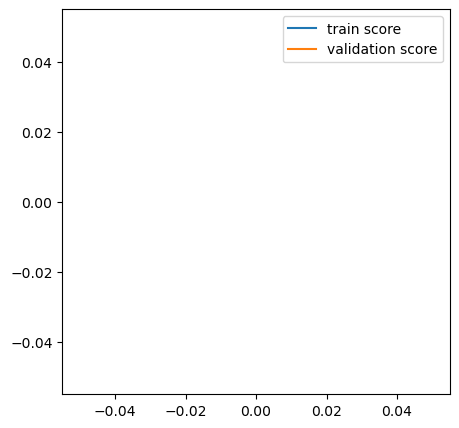

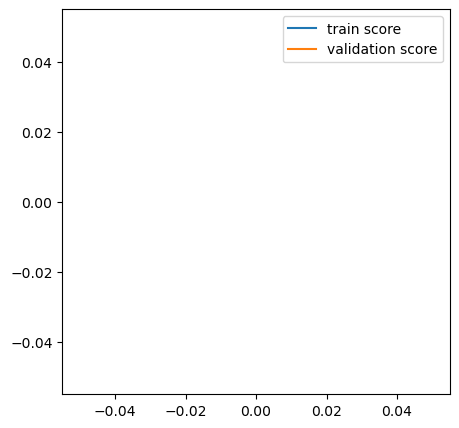

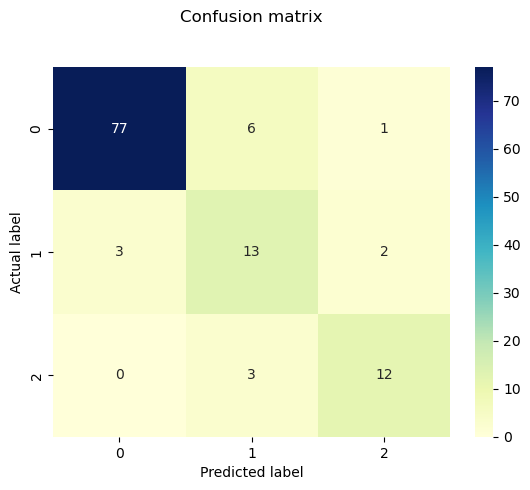

0.8712764903941373


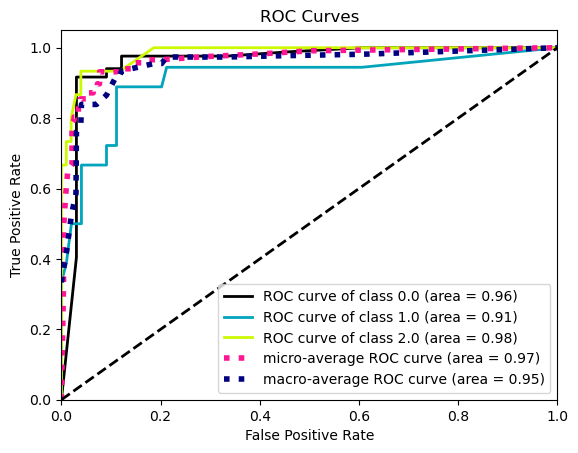

---------------------------------
AdaBoost
Accuracy =  0.2564102564102564
-
[[ 0 83  1]
 [ 0 15  3]
 [ 0  0 15]]
-
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        84
         1.0       0.15      0.83      0.26        18
         2.0       0.79      1.00      0.88        15

    accuracy                           0.26       117
   macro avg       0.31      0.61      0.38       117
weighted avg       0.12      0.26      0.15       117

-


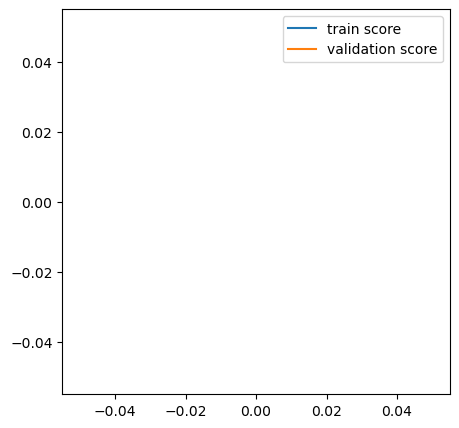

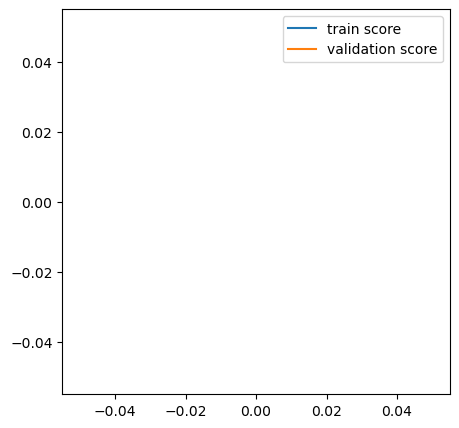

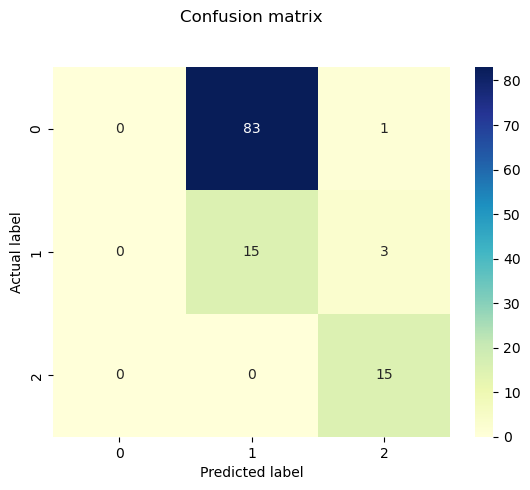

0.6592889681124975


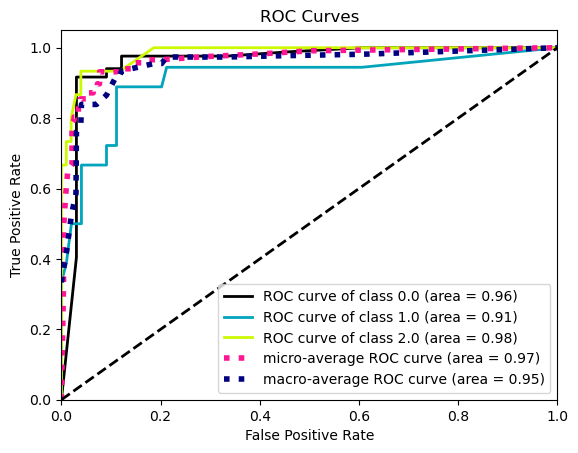

---------------------------------
SVM
Accuracy =  0.8632478632478633
-
[[74  6  4]
 [ 2 14  2]
 [ 2  0 13]]
-
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91        84
         1.0       0.70      0.78      0.74        18
         2.0       0.68      0.87      0.76        15

    accuracy                           0.86       117
   macro avg       0.78      0.84      0.81       117
weighted avg       0.88      0.86      0.87       117

-


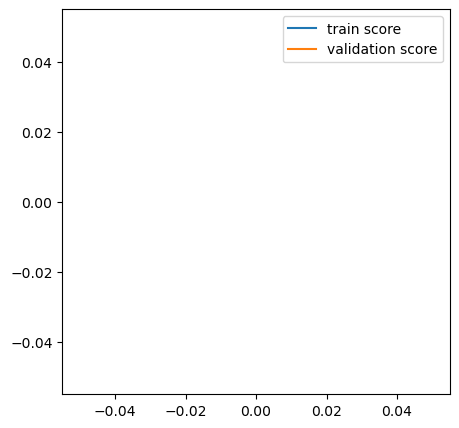

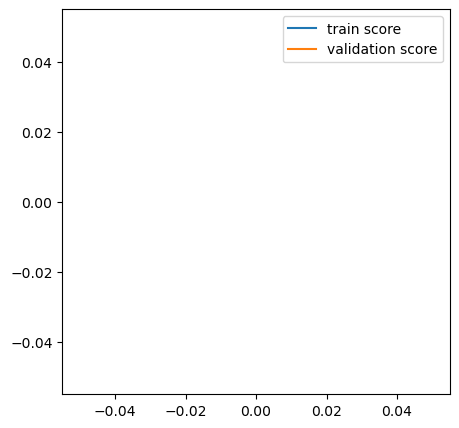

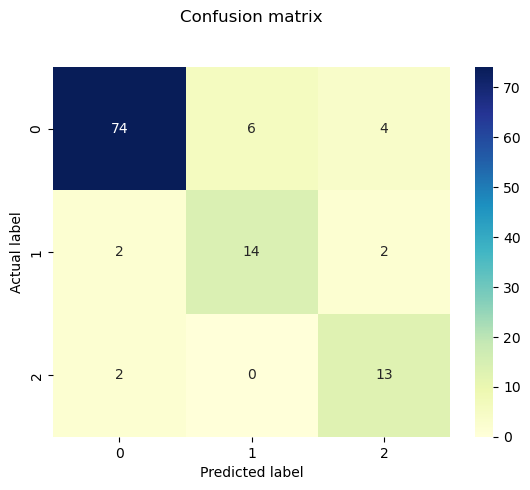

0.8807925190278132


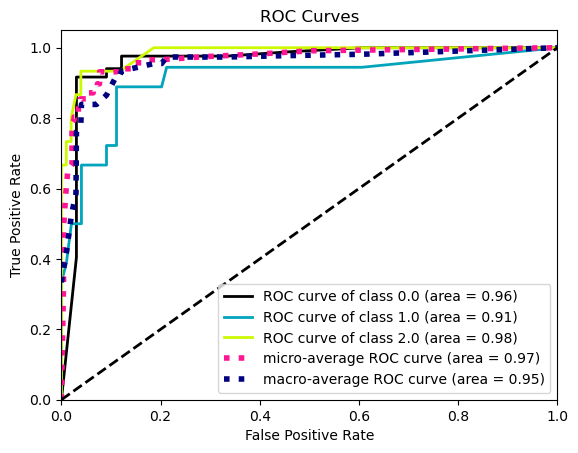

---------------------------------
KNN
Accuracy =  0.8632478632478633
-
[[74  6  4]
 [ 2 14  2]
 [ 1  1 13]]
-
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92        84
         1.0       0.67      0.78      0.72        18
         2.0       0.68      0.87      0.76        15

    accuracy                           0.86       117
   macro avg       0.77      0.84      0.80       117
weighted avg       0.88      0.86      0.87       117

-


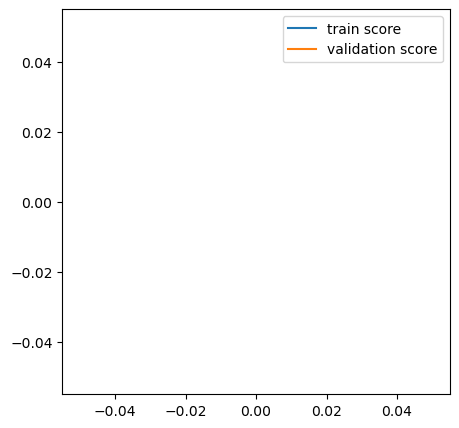

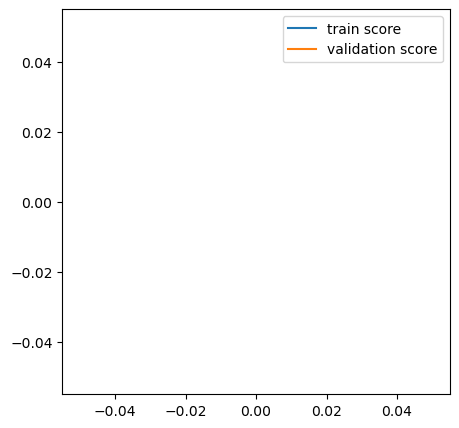

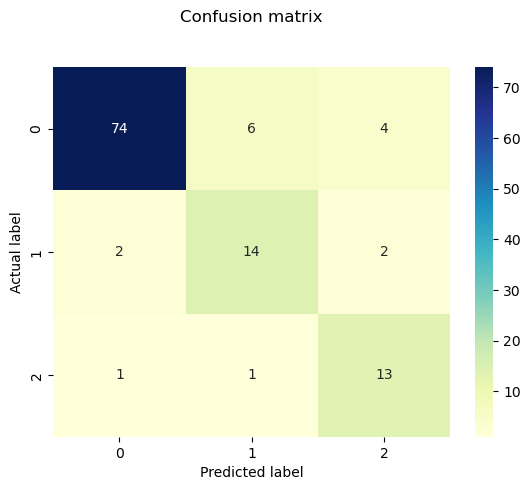

0.8841595223948165


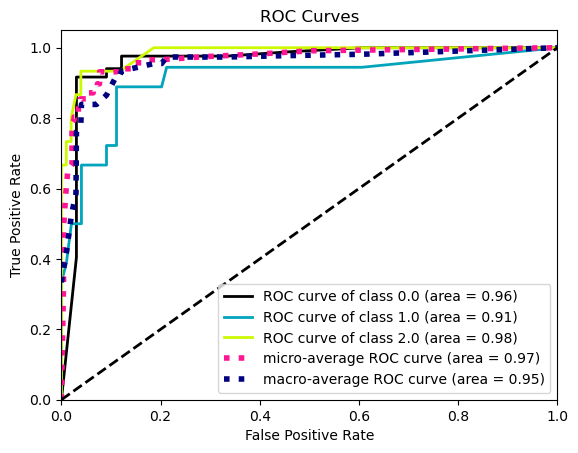

---------------------------------
LR
Accuracy =  0.8632478632478633
-
[[78  5  1]
 [ 3 12  3]
 [ 4  0 11]]
-
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92        84
         1.0       0.71      0.67      0.69        18
         2.0       0.73      0.73      0.73        15

    accuracy                           0.86       117
   macro avg       0.79      0.78      0.78       117
weighted avg       0.86      0.86      0.86       117

-


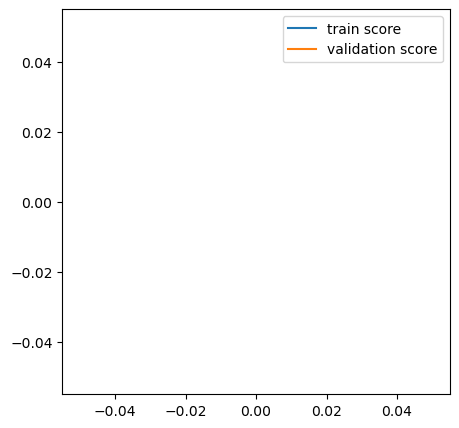

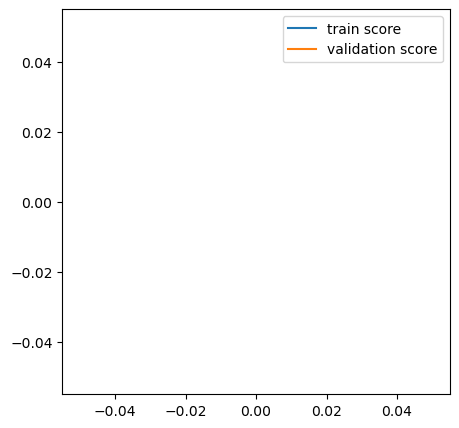

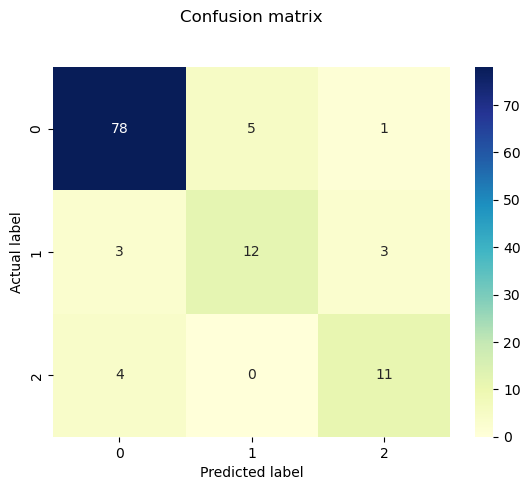

0.8377882466117761


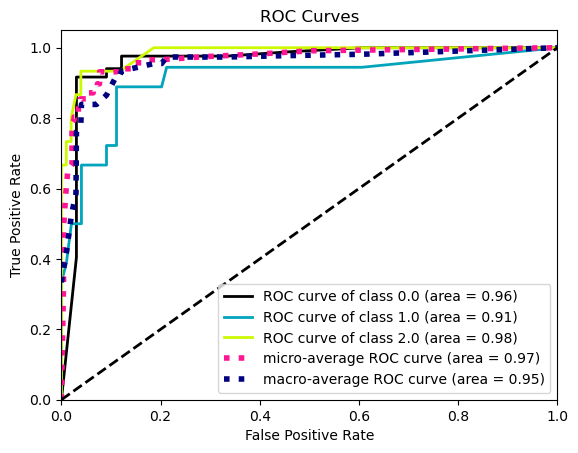

In [26]:
for name, model in dict_of_models.items():
    print('---------------------------------')
    print(name)
    evaluation(model)

## Using RandomForest

In [27]:
RandomPipeline.fit(X_train, y_train)
y_proba = RandomPipeline.predict_proba(X_test)
y_pred = np.argmax(y_proba,axis=1)
print("RandomForest : ", accuracy_score(y_test, y_pred))

RandomForest :  0.8717948717948718


In [28]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [29]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [30]:
print(multiclass_roc_auc_score(y_test, y_pred))

0.8712764903941373


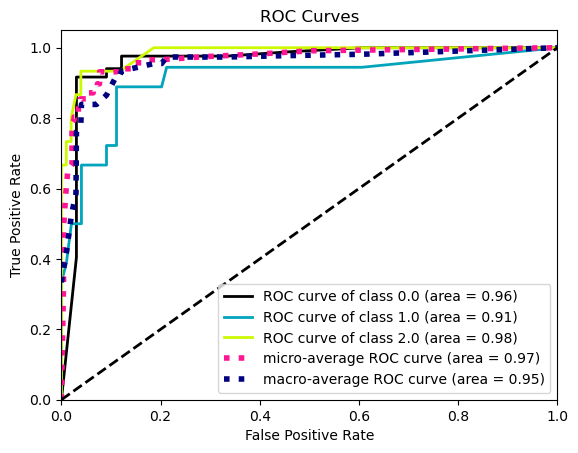

In [31]:
from sklearn.metrics import roc_curve
y_pred_keras_pr = RandomPipeline.predict_proba(X=X_test)
import scikitplot as skplt
plot = skplt.metrics.plot_roc(y_test, y_pred_keras_pr)

### Optimization

In [32]:
from sklearn.model_selection import RandomizedSearchCV
RandomPipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'randomforestclassifier', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__minmaxscaler', 'pipeline__minmaxscaler__clip', 'pipeline__minmaxscaler__copy', 'pipeline__minmaxscaler__feature_range', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [33]:
hyper_params = {
    'randomforestclassifier__n_estimators':[10,100,150,250,400,600],
    'randomforestclassifier__criterion':['gini','entropy'],
    'randomforestclassifier__min_samples_split':[2,6,12],
    'randomforestclassifier__min_samples_leaf':[1,4,6,10],
    'randomforestclassifier__max_features':['auto','srqt','log2',int,float],
    'randomforestclassifier__n_jobs':[-1],
    'randomforestclassifier__verbose':[0,1,2],
    'randomforestclassifier__class_weight':['balanced','balanced_subsample'],
    'randomforestclassifier__n_jobs':[-1],
}

In [34]:
RF_grid = RandomizedSearchCV(RandomPipeline,hyper_params,scoring='accuracy',n_iter=40)
RF_grid.fit(X_train,y_train)
ypred = RF_grid.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tas

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent worker

[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Don

In [35]:
print(classification_report(y_test,ypred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94        84
         1.0       0.59      0.72      0.65        18
         2.0       0.80      0.80      0.80        15

    accuracy                           0.87       117
   macro avg       0.78      0.81      0.80       117
weighted avg       0.88      0.87      0.88       117

0.8717948717948718


## Using XGBoost

Accuracy =  0.8974358974358975
-
[[78  5  1]
 [ 2 13  3]
 [ 0  1 14]]
-
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95        84
         1.0       0.68      0.72      0.70        18
         2.0       0.78      0.93      0.85        15

    accuracy                           0.90       117
   macro avg       0.81      0.86      0.83       117
weighted avg       0.90      0.90      0.90       117

-


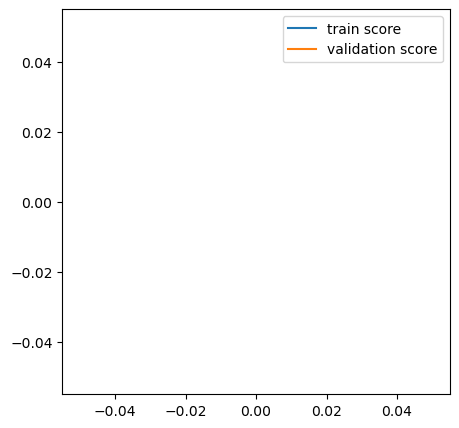

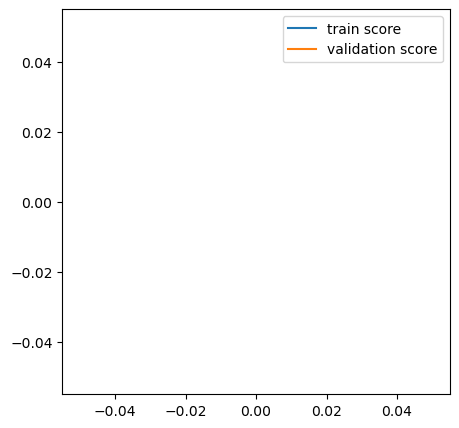

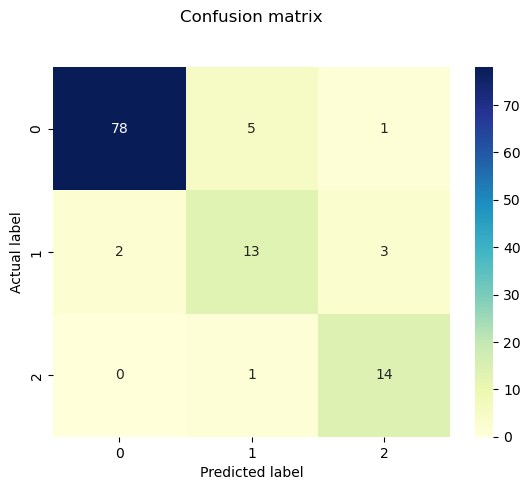

0.9039498627733923


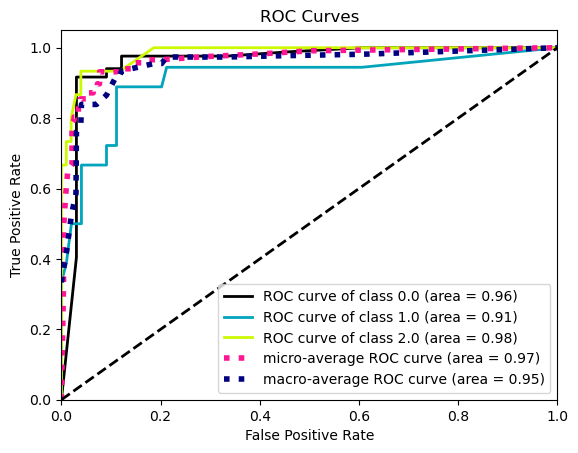

In [38]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
     learning_rate = 0.02,
     n_estimators= 2000,
     max_depth= 4,
     min_child_weight= 2,
     #gamma=1,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     eval_metric = 'logloss',
     nthread= -1,
     scale_pos_weight=1).fit(X_train, y_train)
evaluation (gbm)

In [39]:
y_pred = gbm.predict(X_test)

In [40]:
#! pip install scikit-plot
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [41]:
from sklearn.metrics import classification_report, accuracy_score

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8974358974358975
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95        84
         1.0       0.68      0.72      0.70        18
         2.0       0.78      0.93      0.85        15

    accuracy                           0.90       117
   macro avg       0.81      0.86      0.83       117
weighted avg       0.90      0.90      0.90       117



Text(0.5, 23.52222222222222, 'Predicted label')

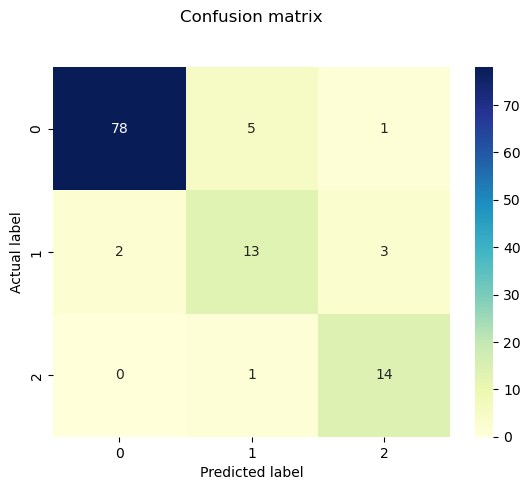

In [42]:
from sklearn import metrics
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [43]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [44]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [45]:
print(multiclass_roc_auc_score(y_test, y_pred))

0.9039498627733923
